In [21]:
import json
import torch
import numpy as np
from inference_v4 import predict_from_checkpoint
#from inference import predict_from_checkpoint
from finpak.data.fetchers.yahoo import download_multiple_tickers
from preprocessing import combine_price_series

from configs import all_configs
from ticker_configs import val_tickers_v9

In [2]:
start_date = '1990-01-01'
end_date = '2024-11-30'

val_tickers_v9 = [
    'DIA', 'SPY', 'QQQ'
]

# Download historical data for the tickers
#data_df = download_multiple_tickers(val_tickers_v3, start_date, end_date)
data_df = download_multiple_tickers(val_tickers_v9, start_date, end_date)
data_df = data_df.loc[:,'Adj Close'] # Extract from multi-index dataframe


# Extract price series for all tickers and convert to tensors
price_series_list = []
for ticker in val_tickers_v9:
    prices = data_df[ticker]
    price_tensor = torch.tensor(prices.to_numpy(), dtype=torch.float32)
    price_series_list.append(price_tensor)

# Combine price series
combined_prices = combine_price_series(price_series_list)

[*********************100%***********************]  3 of 3 completed


In [3]:
data_df.tail()

Ticker,DIA,QQQ,SPY
Date,,,
2024-11-22,443.160004,505.790009,595.510010
2024-11-25,447.559998,506.589996,597.530029
2024-11-26,448.880005,509.309998,600.650024
2024-11-27,447.739990,505.299988,598.830017
2024-11-29,450.089996,509.739990,602.549988


In [4]:
all_configs.keys()

dict_keys(['test', 'vMS0001', 'vMS0002', 'vMS0003', 'vMS0003a', 'vMS0003b', 'vMS0003c', 'vMS0003d', 'vMS0004a', 'vMS0004b', 'test_fourier', 'v0', 'v000', 'v001', 'v002', 'v003', 'v004', 'v005', 'v005a', 'v006', 'v007', 'v008', 'v1', 'v1a', 'v1b', 'v2', 'vMP001a', 'vMP002a', 'vMP003a', 'vMP003b', 'vMP003c', 'vMP003d', 'vMP003e', 'vMP003h', 'vMP003hcat', 'vMP003hcatout', 'vMP004a', 'vMP005a', 'vMP006a', 'vMP007a', 'vMP008a', 'vMP009a', 'vMP009h', 'vMP009h2', 'vMLX01a'])

In [15]:
get_params_dict()

({'stability_threshold': 0.02,
  'dampening_factor': 0.95,
  'ewma_alpha': 0.85,
  'temperature': 0.35,
  'return_scaling': 0.55,
  'beginning_uncertainty': 1e-05,
  'uncertainty_growth': 1e-06,
  'max_uncertainty_single': 0.07,
  'max_uncertainty_multi': 0.15,
  'uncertainty_damping': 0.99},)

In [32]:
def get_inference_params():
    return f"stab_thresh {STABILITY_THRESHOLD}, damp_factor {DAMPENING_FACTOR}, ewma_alpha {EWMA_ALPHA}, temp {TEMPERATURE}, return_scaling_power {RETURN_SCALING_POWER}, base_uncertainty {BASE_UNCERTAINTY}, uncertainty_growth {UNCERTAINTY_GROWTH}, max_uncertainty_single {MAX_UNCERTAINTY_SINGLE}, max_uncertainty_multi {MAX_UNCERTAINTY_MULTI}, uncertainty_damping {UNCERTAINTY_DAMPING}"

def get_params_dict():
    pdict = { CHECKPOINT_NAME: {
                "fname": CHECKPOINT_PATH,
                "inference_parameters":
                {
                    'rating': RATING,
                    'stability_threshold': STABILITY_THRESHOLD,
                    'dampening_factor': DAMPENING_FACTOR,
                    'ewma_alpha': EWMA_ALPHA,
                    'temperature': TEMPERATURE,
                    'return_scaling': RETURN_SCALING_POWER,
                    'beginning_uncertainty': BASE_UNCERTAINTY,
                    'uncertainty_growth': UNCERTAINTY_GROWTH,
                    'max_uncertainty_single': MAX_UNCERTAINTY_SINGLE,
                    'max_uncertainty_multi': MAX_UNCERTAINTY_MULTI,
                    'uncertainty_damping': UNCERTAINTY_DAMPING
                }
            }
        }
    return json.dumps(pdict, indent=4)

#get_inference_params()
RATING = 'very good - stays more in bounds - less directional'
print(get_params_dict())


{
    "vMP009h_id_0_arc_v4_tc15_vc14_e2997_valloss_0.0000232.pt": {
        "fname": "checkpoints/vMP009h_id_0_arc_v4_tc15_vc14_e2997_valloss_0.0000232.pt",
        "inference_parameters": {
            "rating": "very good - stays more in bounds - less directional",
            "stability_threshold": 0.02,
            "dampening_factor": 0.95,
            "ewma_alpha": 0.85,
            "temperature": 0.05,
            "return_scaling": 0.001,
            "beginning_uncertainty": 1e-05,
            "uncertainty_growth": 1e-06,
            "max_uncertainty_single": 0.03,
            "max_uncertainty_multi": 0.08,
            "uncertainty_damping": 0.99
        }
    }
}


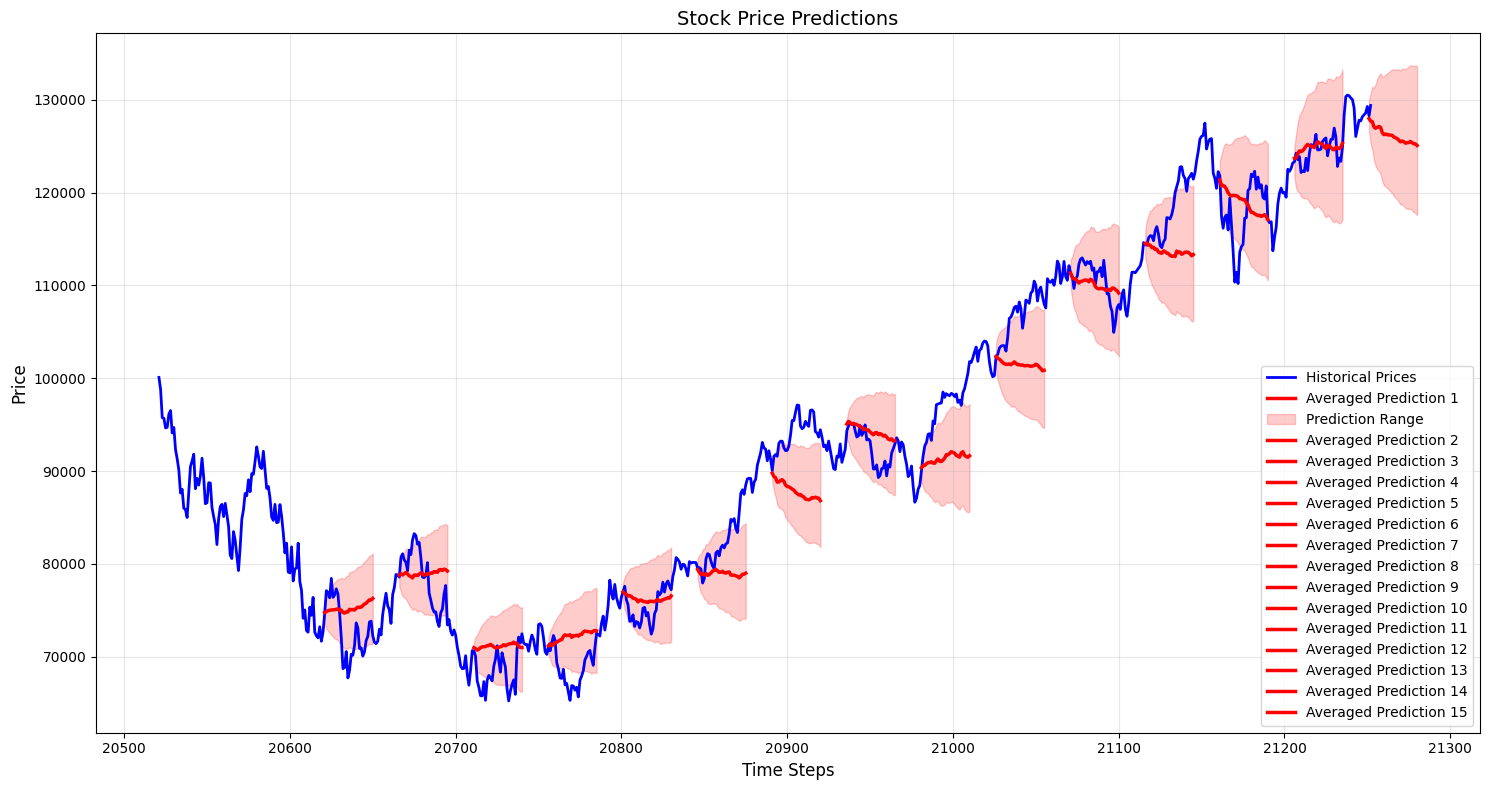

Using checkpoint:  checkpoints/vMP009h_id_0_arc_v4_tc15_vc14_e2997_valloss_0.0000232.pt


In [33]:
# Model Selection
CONFIG_NAME = 'vMP009h'

CHECKPOINT_NAME = 'vMP009h_id_0_arc_v4_tc15_vc14_e2997_valloss_0.0000232.pt'
CHECKPOINT_PATH = f'checkpoints/{CHECKPOINT_NAME}'

# Prediction Parameters
N_FUTURE_STEPS = 30
USE_SAMPLING = True
TEMPERATURE = 0.05 # 0.3 # 0.1  # Controls prediction randomness (higher = more random) - temporarily set to 0.7

# Stability Parameters
STABILITY_THRESHOLD = 0.02 # 0.015  # Max allowed daily return (decrease for more stability)
DAMPENING_FACTOR = 0.95  #   0.65    # Price dampening (decrease for more stability)
EWMA_ALPHA = 0.85 # 0.2          # Price smoothing (decrease for more stability)
RETURN_SCALING_POWER = 0.001 # 0.55 1 # Increase to scale down longer term returns more and decrease to increase their impact

# Uncertainty Parameters - higher uncertainty = wider cones
BASE_UNCERTAINTY = 0.00001 # 0.0005 # Initial uncertainty level (as fraction)
UNCERTAINTY_GROWTH = 0.000001 # 0.00025 # Rate at which uncertainty grows per step (as fraction)
MAX_UNCERTAINTY_SINGLE = 0.03 # 0.1 # Maximum bounds for single horizon (±20%)
MAX_UNCERTAINTY_MULTI = 0.08 # 0.25 # Maximum bounds for multi horizon (±50%)
UNCERTAINTY_DAMPING = 0.99 # 0.05 # Dampening factor for uncertainty growth - higher is more dampening = narrower cones

# Multi-horizon Parameters
USE_MULTI_HORIZON = True # False # Ideally set to True
HORIZON_WEIGHTS = None     # Optional: e.g. [0.5, 0.5] to weight different prediction horizons

# Teacher Forcing Parameters
USE_FORCING = False
FORCING_HALFLIFE = 3.0

# Index Generation Parameters
TOP_LEVEL_INDICES = np.arange(0, 660, 45).tolist()
OFFSET_STEPS = [-1, -2, -3 -4, -5, -1, -2, -3 -4, -5, -1, -2, -3 -4, -5, -1, -2, -3 -4, -5] # [-5, -10, -15, -20, -25]

# ============= Config-Derived Parameters =============
# Load config
CONFIG = all_configs[CONFIG_NAME]
MODEL_PARAMS = CONFIG['model_params'].copy()
MODEL_PARAMS.pop('dropout', None)  # Remove dropout for inference

# Get sequence and feature parameters from config
sequence_length = CONFIG['data_params']['sequence_length']
return_periods = CONFIG['data_params']['return_periods']
sma_periods = CONFIG['data_params']['sma_periods']
target_periods = CONFIG['data_params']['target_periods']
momentum_periods = CONFIG['data_params']['momentum_periods']

# Calculate input dimension
d_input = 0
d_input += len(return_periods)  # Return features
d_input += len(sma_periods)     # SMA features
if CONFIG['data_params']['use_momentum']:
    d_input += len(CONFIG['data_params']['momentum_periods'])
if CONFIG['data_params']['use_volatility']:
    d_input += len(return_periods)

# Calculate output dimension
n_outputs = len(target_periods)

# Update model parameters
MODEL_PARAMS['d_input'] = d_input
MODEL_PARAMS['n_outputs'] = n_outputs

# ============= Index Generation =============
# Calculate required history
max_lookback = max([
    max(sma_periods) if sma_periods else 0,
    max(momentum_periods) if momentum_periods else 0,
    max(return_periods),
    max(target_periods)
])
total_required_history = sequence_length + max_lookback

# Find last valid index
last_valid_idx = torch.where(torch.isfinite(combined_prices))[0][-1].item()

# Generate valid start indices
start_indices = []
for base_idx in TOP_LEVEL_INDICES:
    for offset in OFFSET_STEPS:
        idx = last_valid_idx - (base_idx + abs(offset))
        if idx >= total_required_history:
            start_indices.append(idx)

averaged_indices = []
for base_idx in TOP_LEVEL_INDICES:
    sub_indices = []
    for offset in OFFSET_STEPS:
        idx = last_valid_idx - (base_idx + abs(offset))
        if idx >= total_required_history:
            sub_indices.append(idx)
    averaged_indices.append(sub_indices)

start_indices = None


# ============= Make Predictions =============
predict_from_checkpoint(
    checkpoint_path=CHECKPOINT_PATH,
    price_series=combined_prices, # combined_prices,
    start_indices=start_indices,
    averaged_indices=averaged_indices,
    n_steps=N_FUTURE_STEPS,
    config=CONFIG,
    model_params=MODEL_PARAMS,
    use_multi_horizon=USE_MULTI_HORIZON,
    stability_threshold=STABILITY_THRESHOLD,  # Max % daily move - decrease for more stability
    dampening_factor=DAMPENING_FACTOR,  # Stronger dampening - decrease for more stability
    ewma_alpha=EWMA_ALPHA,  # More smoothing - decrease for more stability
    horizon_weights=HORIZON_WEIGHTS, # [0.5, 0.5], # [0.3, 0.7],
    use_forcing=USE_FORCING,
    forcing_halflife=FORCING_HALFLIFE,
    temperature=TEMPERATURE,
    use_sampling=USE_SAMPLING,
    return_scaling_power=RETURN_SCALING_POWER,
    base_uncertainty=BASE_UNCERTAINTY,
    uncertainty_growth=UNCERTAINTY_GROWTH,
    max_uncertainty_single=MAX_UNCERTAINTY_SINGLE,
    max_uncertainty_multi=MAX_UNCERTAINTY_MULTI,
    uncertainty_damping=UNCERTAINTY_DAMPING,
    debug=False,
)
print("Using checkpoint: ", CHECKPOINT_PATH)

In [6]:
type(combined_prices)

torch.Tensor

In [7]:
typs = [type(x) for x in combined_prices]
print(set(typs))

{<class 'torch.Tensor'>}


In [8]:
torch.where(torch.isnan(combined_prices), torch.zeros_like(combined_prices), combined_prices)

tensor([4.4508e+01, 4.3961e+01, 4.3590e+01,  ..., 1.2928e+05, 1.2826e+05,
        1.2939e+05])

In [9]:
torch.where(torch.isinf(combined_prices), torch.zeros_like(combined_prices), combined_prices)

tensor([4.4508e+01, 4.3961e+01, 4.3590e+01,  ..., 1.2928e+05, 1.2826e+05,
        1.2939e+05])

In [10]:
min(combined_prices), max(combined_prices), combined_prices[:20], combined_prices[-20:]

(tensor(42.6732),
 tensor(130504.1250),
 tensor([44.5077, 43.9606, 43.5900, 43.4841, 43.6605, 44.1724, 44.6842, 44.8430,
         44.7459, 45.7519, 46.1136, 45.8666, 45.8754, 46.3695, 46.1842, 46.9607,
         46.9607, 47.2607, 47.2343, 47.4725]),
 tensor([123724.3203, 123363.8828, 124937.6250, 128331.3281, 130351.8125,
         130504.1250, 130427.9766, 130191.8984, 130024.3828, 129120.7422,
         126044.3281, 126920.0391, 127793.2109, 127719.6094, 128179.0391,
         128384.6406, 128587.7031, 129278.1172, 128260.2578, 129387.2656]))